# ANLY 580 Project 2

## Text Classification
This part focuses on using deep learning <b>recurrent neural network (RNN)</b> to classify the label of steam reviews (recommend vs not-recommend). The results are then evaluated later based on training and testing <b>accuracy/loss</b> and actual classification results (measured in <b>ROC curve</b> and <b>confusion matrix</b>).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import Dropout, Input, Embedding, LSTM
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import string
import re

In [2]:
# load the data
df = pd.read_csv('steam_reviews.csv')

Below is the top 5 lanes of the steam reviews data, we are primarily focusing on <b>review</b> as predictive variable and <b>recommendation</b> as response variable.

In [3]:
df.head(5)

,date_posted,funny,helpful,hour_played,is_early_access_review,recommendation,review,title
0,2019-02-10,2,4,578,False,Recommended,&gt Played as German Reich&gt Declare war on B...,Expansion - Hearts of Iron IV: Man the Guns
1,2019-02-10,0,0,184,False,Recommended,yes.,Expansion - Hearts of Iron IV: Man the Guns
2,2019-02-07,0,0,892,False,Recommended,Very good game although a bit overpriced in my...,Expansion - Hearts of Iron IV: Man the Guns
3,2018-06-14,126,1086,676,False,Recommended,Out of all the reviews I wrote This one is pro...,Dead by Daylight
4,2017-06-20,85,2139,612,False,Recommended,Disclaimer I survivor main. I play games for f...,Dead by Daylight


### Data Cleaning
This part focus on cleaning the reviews data by removing missing values, non-helpful reviews, some common words and non-ascii encoding words to ensure the quality of the input before training the deep learning model

In [4]:
df_clean = df[df.review.notnull()] #filter missing value
df_clean = df_clean[df_clean['helpful'] != 0] #filter non-helpful review

In [5]:
# NLTK Stop words
# Define our stoplist for removing common words and tokenizing
list1 = ['RT','rt', '&amp;', 'im', 'b4', 'yr', 'nd', 'rd', 'oh', "can't", "he's", "i'll",
         "i'm", 'ta', "'s", "c'mon", 'th', 'st', "that's", "they're", "i've", 'am', 'pm']
list2 = ['good','nice','awesome','cool','perfect','like','very','&gt','well','sucks','damn','bad','great','XD','&lt','best','ok','suck','shit','s','u','c','k','garbage','noob','trash']
stoplist = stopwords.words('english') + list(string.punctuation) + list1 + list2

In [7]:
# further clean review by removing user tags marks and so on 
corpus_rec = []
for i in df_clean['review']:
    comm = i    
    comm = re.sub(r'http\S+', '', comm) #remove url's    
    #remove hashtags and mentions
    comm = re.sub(r'#\w+ ?', '', comm)
    comm = re.sub(r'@\w+ ?', '', comm)
    comm = comm.replace("&amp;", " ").replace("&gt;", "").replace("&lt;", "")
    #remove curly bracket
    comm = comm.replace("(", "").replace(")", "").replace(".", "").replace("?", "").replace("!", "").replace(",", "")
    comm = comm.replace("/", " ").replace("=", "").replace('\"', "").replace('*', '').replace(';', "")
    comm = comm.replace(':', '').replace('"', '')
    comm = re.sub(r'\$[0-9]+', '', comm)
    comm = re.sub(r'[0-9]+GB', '', comm)
    comm = re.sub(r'[0-9]+', '', comm)
    comm = re.sub(r'--+', ' ', comm)
    #remove non-ascii encoding words (non-alphabetical)
    comm = comm.encode("ascii", errors="ignore").decode()
    corpus_rec.append(comm)

Now let's visualize the cleaned results below:

In [8]:
df_clean['review_clean'] = corpus_rec

In [10]:
# encode the label (recommend vs non-recommend to 1 and 0 for trainbing purpose)
df_clean['label'] = np.where(df_clean['recommendation']=='Recommended', 1, 0)

In [11]:
df_clean.head()

,date_posted,funny,helpful,hour_played,is_early_access_review,recommendation,review,title,review_clean,label
0,2019-02-10,2,4,578,False,Recommended,&gt Played as German Reich&gt Declare war on B...,Expansion - Hearts of Iron IV: Man the Guns,&gt Played as German Reich&gt Declare war on B...,1
3,2018-06-14,126,1086,676,False,Recommended,Out of all the reviews I wrote This one is pro...,Dead by Daylight,Out of all the reviews I wrote This one is pro...,1
4,2017-06-20,85,2139,612,False,Recommended,Disclaimer I survivor main. I play games for f...,Dead by Daylight,Disclaimer I survivor main I play games for fu...,1
5,2016-12-12,4,55,2694,False,Recommended,ENGLISH After playing for more than two years ...,Dead by Daylight,ENGLISH After playing for more than two years ...,1
6,2017-09-17,12,228,48,False,Recommended,Out of all the reviews I wrote This one is pro...,Dead by Daylight,Out of all the reviews I wrote This one is pro...,1


### Recurrent Neural Network
This part focuses on preparing, designing and training a recurrent neural network to predict the labels based on embeded word vectors. The hyper parameters are customized for several different sets and after trying some different combinations, below is the best among all the models:

In [16]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 30000
# Max number of words in each review
MAX_SEQUENCE_LENGTH = 1000
# Number of embedding dimensions (projection)
EMBEDDING_DIM = 100

In [ ]:
# Additional tokenization 
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df_clean['review_clean'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

In [18]:
# Parse reviews' text to embedding vectors 
X = tokenizer.texts_to_sequences(df_clean['review_clean'].values)
X = sequence.pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
Y = df_clean['label'].values

print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', Y.shape)

Shape of data tensor: (35071, 1000)
Shape of label tensor: (35071,)


Split the training and testing set

In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(31563, 1000) (31563,)
(3508, 1000) (3508,)


In [20]:
# set up RNN structure
def SetupModel():    
    model = Sequential()
    model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train.shape[1]))
    model.add(Dropout(0.2))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    return(model)

# set up number of epoches batch size
epochs = 5
batch_size = 32

In [21]:
SetupModel().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 100)         3000000   
_________________________________________________________________
dropout (Dropout)            (None, 1000, 100)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 3,080,501
Trainable params: 3,080,501
Non-trainable params: 0
_________________________________________________________________


In [22]:
# adjust the hyper-parameters of Adam optimizer
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

In [23]:
# compile model and fit the training set
model_adam = SetupModel()
model_adam.compile(loss='binary_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])

history_adam = model_adam.fit(X_train, Y_train, 
                    epochs=epochs, batch_size=batch_size, validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 28406 samples, validate on 3157 samples
Epoch 1/5
28406/28406 [==============================] - 721s 25ms/sample - loss: 0.5261 - accuracy: 0.7386 - val_loss: 0.4500 - val_accuracy: 0.7925
Epoch 2/5
28406/28406 [==============================] - 712s 25ms/sample - loss: 0.4095 - accuracy: 0.8215 - val_loss: 0.5145 - val_accuracy: 0.7399
Epoch 3/5
28406/28406 [==============================] - 712s 25ms/sample - loss: 0.3509 - accuracy: 0.8480 - val_loss: 0.4464 - val_accuracy: 0.7960
Epoch 4/5
28406/28406 [==============================] - 712s 25ms/sample - loss: 0.3093 - accuracy: 0.8681 - val_loss: 0.4973 - val_accuracy: 0.7989
Epoch 5/5
28406/28406 [==============================] - 710s 25ms/sample - loss: 0.2795 - accuracy: 0.8825 - val_loss: 0.4915 - val_accuracy: 0.7954


### Result (RNN Model)
Below are the results generated by RNN model, in term of training/testing accuracy, loss with different epochs

In [24]:
# evaluate the result
### overall
score_train_adam = model_adam.evaluate(X_train,Y_train,verbose=0)
score_test_adam = model_adam.evaluate(X_test,Y_test,verbose=0)

# training/testing acc/loss
loss_train_adam = score_train_adam[0]
loss_test_adam = score_test_adam[0]
acc_train_adam = score_train_adam[1]
acc_test_adam = score_test_adam[1]

### epoch wise
train_acc_trend_adam = history_adam.history['accuracy']
train_loss_trend_adam = history_adam.history['loss']
val_acc_trend_adam = history_adam.history['val_accuracy']
val_loss_trend_adam = history_adam.history['val_loss']

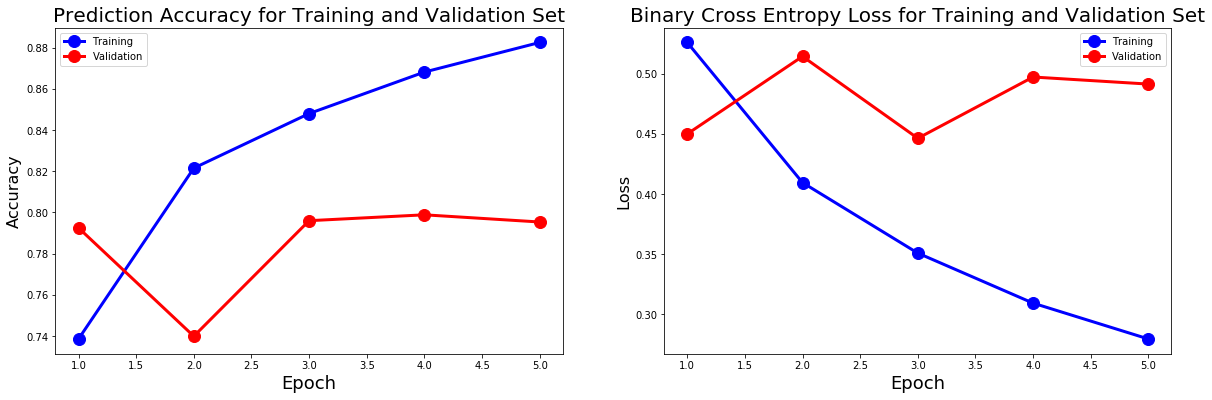

In [25]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,6))

#### accuarcy
result_acc_train = pd.DataFrame({
    'x':range(1,6),
    'Training': train_acc_trend_adam,
    'Validation': val_acc_trend_adam
    })

ax1.plot('x', 'Training', data=result_acc_train, marker='o', color='blue', linewidth=3,markersize=12)
ax1.plot('x', 'Validation', data=result_acc_train, marker='o', color='red', linewidth=3,markersize=12)
ax1.set_title('Prediction Accuracy for Training and Validation Set', fontsize=20)
ax1.set_xlabel('Epoch', fontsize=18)
ax1.set_ylabel('Accuracy', fontsize=16)
ax1.legend(fontsize = 10)


#### loss
result_loss_train = pd.DataFrame({
    'x':range(1,6),
    'Training': train_loss_trend_adam,
    'Validation': val_loss_trend_adam
    })

ax2.plot('x', 'Training', data=result_loss_train, marker='o', color='blue', linewidth=3,markersize=12)
ax2.plot('x', 'Validation', data=result_loss_train, marker='o', color='red', linewidth=3,markersize=12)
ax2.set_title('Binary Cross Entropy Loss for Training and Validation Set', fontsize=20)
ax2.set_xlabel('Epoch', fontsize=18)
ax2.set_ylabel('Loss', fontsize=16)
ax2.legend(fontsize = 10)

From two plots above, we can see there’s a clear overfitting after epoch 2 for the RNN model, as accuracy for validation set converges at around 0.79 and training set still increases. This might due to the fact that our training set is small compared to the RNN structure, which tends to be too flexible for detecting the patterns of recommend and not-recommend reviews

### Result (Classification)
The binary classification result on the testing set is evaluated based on the the ROC curve and confusion matrix.

In [26]:
from sklearn.metrics import roc_curve
y_pred_keras = model_adam.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_test, y_pred_keras)

In [27]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

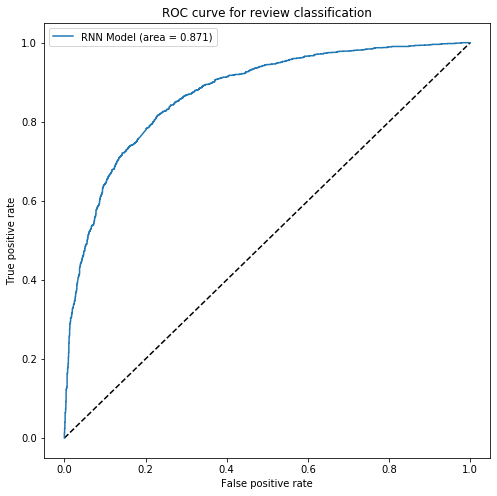

In [33]:
plt.figure(figsize=(8,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='RNN Model (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for review classification')
plt.legend(loc='best')
plt.show()

In [79]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Only use the labels that appear in the data
    classes = classes

    print(cm)

    fig, ax = plt.subplots(figsize=(10,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[1285  344]
 [ 392 1487]]


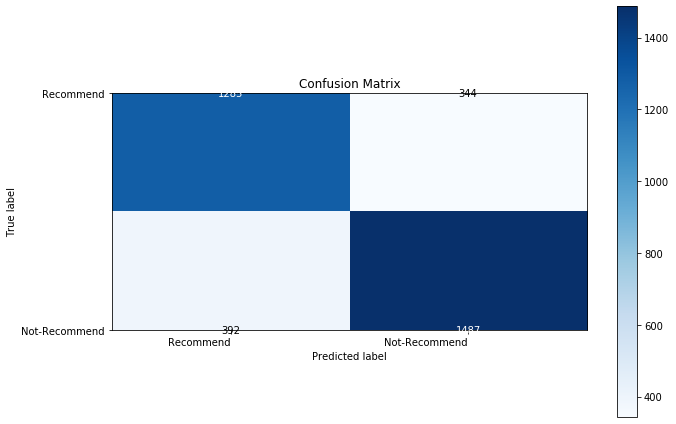

In [80]:
cm = np.asarray([[1285,344],[392,1487]])
plot_confusion_matrix(cm, classes=['Recommend','Not-Recommend'],
                      title='Confusion Matrix')

From the ROC curve, we can see the AUC for classification is around 0.871 and confusion matrix shows the overall accuracy rate is around 0.7902, which is roughly the same as the validation accuracy at epoch 2. The model also is more robust to classify not-recommend reviews compared to recommend reviews, as 1285 recommend reviews and 1487 not-recommend reviews are classified corretly.

### Summary
<br>This jupyter notebook explores using deep learning RNN model to classify text because RNN model helps preserve the information from former part of a sentence and iterate over to update the weights accordingly. The deep learning model is designed to fit in specifically the steam review and used to classify the binary labels (recommend/not recommend). </br>
<br>The results are evaluated by the training/testing accuracy and loss for each epoch, and overfitting is detected if the validation results are converged early. The final classification results are evaluated by ROC and confusion matrix, and the overall performance is roughly the same as the training model suggests.</br>